Постановка задачи: проверить будет ли компания успешной в случае проведение рекламы. Для анализа представлена выборка из двух групп. Группа 'ad' - человек видел рекламу, группа 'psa' он видел только объявление государственной службы.

# Установка и импорт библиотек

In [3]:
!pip install numpy pandas seaborn matplotlib --quiet
!pip install scipy statsmodels --quiet

In [4]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import shapiro, norm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

import warnings
warnings.filterwarnings("ignore")

# Считывание данных

In [6]:
original_data = pd.read_csv("../data/A_B_marketing/marketing_AB.csv")

In [7]:
original_data.shape

(588101, 7)

# Исследование и обработка данных

## Первичный обзор

In [10]:
original_data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [11]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [12]:
original_data.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279667,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


* В данных нет пропусков
* most ads day надо бы преобразовать в число дня недели
* test group в категориальный признак: A/B
* total ads в среднем 24, но максимальное 2065 - возможно есть выбросы.

Посчитаем количество выбросов:

### most ads day

In [15]:
original_data['most ads day'].unique()

array(['Monday', 'Tuesday', 'Friday', 'Saturday', 'Wednesday', 'Sunday',
       'Thursday'], dtype=object)

In [16]:
day_of_week_dict = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

### test group

In [18]:
original_data['test group'].value_counts()

test group
ad     564577
psa     23524
Name: count, dtype: int64

In [19]:
test_group_dict = {
    'ad': 'A',
    'psa': 'B',
}

### total ads

In [21]:
Q1 = original_data['total ads'].quantile(0.25)
Q3 = original_data['total ads'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers = original_data[original_data['total ads'] > upper_bound]
print(f'{outliers['total ads'].count()} выбросов с минимальным значением {outliers['total ads'].min()}')

52057 выбросов с минимальным значением 62


62 рекламы человек мог увидеть, сделаем отсечку повыше

In [23]:
original_data[original_data['total ads'] > 500]['total ads'].count()

585

Вот это и удалим в пайплайне.

## Преобразование данных

In [26]:
class RemoveOutliersPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X[X['total ads'] < 500]
        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [27]:
class TypeCastPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['most ads day'].replace(day_of_week_dict, inplace=True)
        X['test group'].replace(test_group_dict, inplace=True)
        X['test group'] = X['test group'].astype('category')
        
        X.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

### Удаление пользователей, которые попали в обе группы

In [29]:
class RemoveDoubleUsersPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        user_group_counts = X.groupby('user id')['test group'].nunique()
        users_in_multiple_groups = user_group_counts[user_group_counts > 1].index
        X = X[~X['user id'].isin(users_in_multiple_groups)]
        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

Но в нашем датасете таких нет.

## Анализ обработанного датасета

In [32]:
pipeline_preprocessing = Pipeline([
    ('outliers_filter', RemoveOutliersPreprocessing()),
    ('type_cast', TypeCastPreprocessing()),
    ('users_in_two_groups', RemoveDoubleUsersPreprocessing()),
])

In [33]:
data = pipeline_preprocessing.fit_transform(original_data.copy(deep=True))

In [34]:
data.head()

,id,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,A,False,130,1,20
1,1,1119715,A,False,93,2,22
2,2,1144181,A,False,21,2,18
3,3,1435133,A,False,355,2,10
4,4,1015700,A,False,276,5,14


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 587512 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   id             587512 non-null  int64   
 1   user id        587512 non-null  int64   
 2   test group     587512 non-null  category
 3   converted      587512 non-null  bool    
 4   total ads      587512 non-null  int64   
 5   most ads day   587512 non-null  int64   
 6   most ads hour  587512 non-null  int64   
dtypes: bool(1), category(1), int64(5)
memory usage: 28.0 MB


In [36]:
data.describe()

,id,user id,total ads,most ads day,most ads hour
count,587512.000000,5.875120e+05,587512.000000,587512.000000,587512.000000
mean,294300.120197,1.310655e+06,24.168696,4.025870,14.470288
std,169665.530025,2.022310e+05,38.092996,2.004091,4.834749
min,0.000000,9.000000e+05,1.000000,1.000000,0.000000
25%,147457.750000,1.143135e+06,4.000000,2.000000,11.000000
50%,294344.500000,1.313662e+06,13.000000,4.000000,14.000000
75%,441222.250000,1.484058e+06,27.000000,6.000000,18.000000
max,588100.000000,1.654483e+06,499.000000,7.000000,23.000000


# Первичный анализ результатов A/B-тестирования

## Рассчет показателей

Рассчитаем показатели для контрольной и тестовой групп:
* количество посещений сайта(total_visited)
* суммарное количество совершённых покупок(total_purchases)
* среднее количество рекламы(mean_ads_count)
* процент конверсии(conversion)

In [40]:
total_group_data = data.groupby(['test group']).agg({
    'user id': 'count',
    'converted': 'sum',
    'total ads': 'mean',
}).reset_index().rename(columns={
    'test group': 'group',
    'user id': 'total_visited',
    'converted': 'total_purchases',
    'total ads': 'mean_ads_count',
})
total_group_data['conversion'] = total_group_data.apply(
    lambda x: x['total_purchases'] / x['total_visited'] * 100,
    axis=1,
)
total_group_data.head()

,group,total_visited,total_purchases,mean_ads_count,conversion
0,A,564007,14323,24.163390,2.539507
1,B,23505,418,24.296022,1.778345


In [41]:
group_A_count = total_group_data[total_group_data['group'] == 'A']['total_visited'].iloc[0]
group_B_count = total_group_data[total_group_data['group'] == 'B']['total_visited'].iloc[0]

total_count = group_A_count + group_B_count
group_B_percent = group_B_count / total_count * 100
print(f'Общее количество посещений сайта: {total_count}')
print(f'Группа А составляет {round((100 - group_B_percent), 3)}%, а группа B {round(group_B_percent, 3)}%')

Общее количество посещений сайта: 587512
Группа А составляет 95.999%, а группа B 4.001%


Рассчитаем размер выборки по калькулятору Эвана Миллера, у нас:
* конверсия существующего варианта 2.54%
* минимально желаемый результат изменения метрики зададим абсолютным 0.5%
* мощность теста зададим 90%
* уровень значимости зададим 5%

тогда размер выборки должен быть 21582 на каждую группу, у нас есть столько элементов в каждой группе, однако выборки сильно не сбалансированы, вместо желаемых 50%/50% у нас 96%/4%

## Визуализация

In [44]:
day_group_data = data.groupby(['test group', 'most ads day']).agg({
    'user id': 'count',
    'converted': 'sum',
    'total ads': 'mean',
}).reset_index().rename(columns={
    'test group': 'group',
    'user id': 'total_visited',
    'converted': 'total_purchases',
    'total ads': 'mean_ads_count',
})
day_group_data['conversion'] = day_group_data.apply(
    lambda x: x['total_purchases'] / x['total_visited'] * 100,
    axis=1,
)
day_group_data.head(20)

,group,most ads day,total_visited,total_purchases,mean_ads_count,conversion
0,A,1,83455,2750,24.492888,3.295189
1,A,2,74513,2254,23.509857,3.024976
2,A,3,77323,1945,23.776923,2.515422
3,A,4,79011,1701,22.726646,2.152865
4,A,5,88679,1978,25.720825,2.230517
5,A,6,78734,1670,24.583471,2.121066
6,A,7,82292,2025,24.083350,2.460750
7,B,1,3499,79,23.373535,2.257788
8,B,2,2906,42,20.966965,1.445286
9,B,3,3487,55,22.538859,1.577287


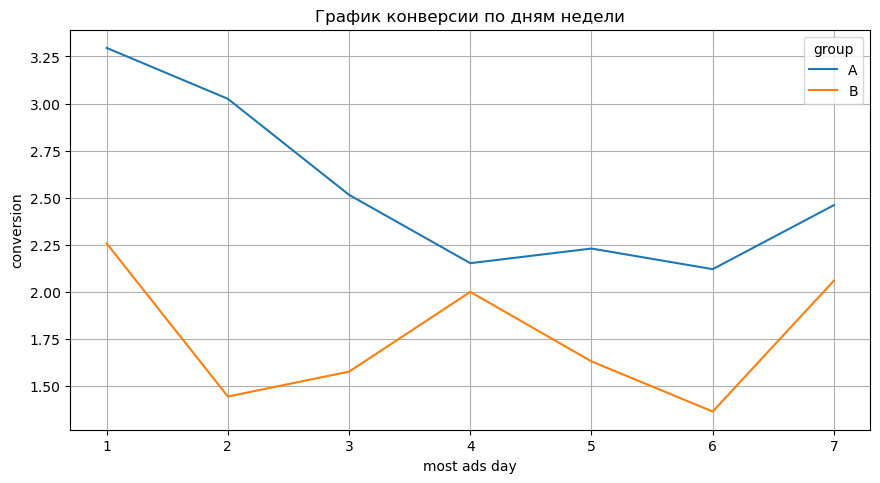

In [45]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=day_group_data,
    x='most ads day',
    y='conversion',
    hue='group', 
    ax=ax
)
ax.set_title('График конверсии по дням недели')
ax.grid(True);

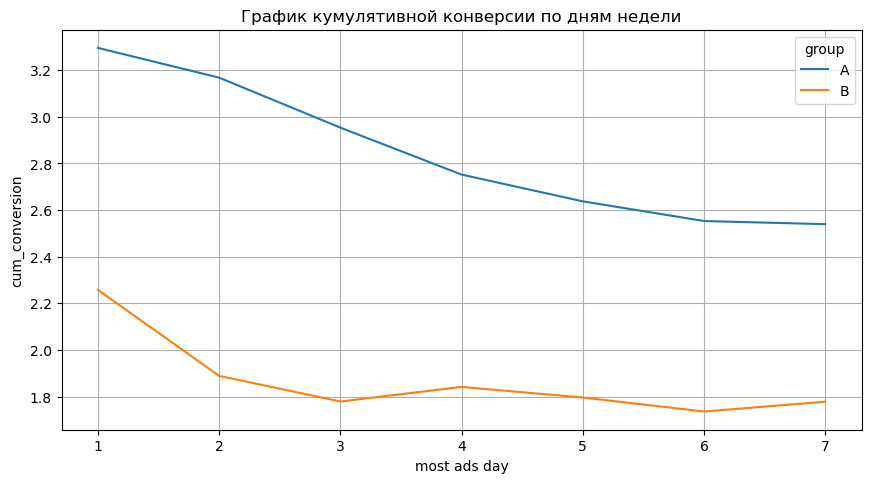

In [46]:
day_group_data['cum_total_visited'] = day_group_data.groupby(['group'])['total_visited'].cumsum()
day_group_data['cum_total_purchases'] = day_group_data.groupby(['group'])['total_purchases'].cumsum()
day_group_data['cum_conversion'] = day_group_data['cum_total_purchases']\
    /day_group_data['cum_total_visited'] * 100

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='most ads day', y='cum_conversion', data=day_group_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням недели')
ax.grid(True);

## Первичный вывод

Первичный вывод о результатах A/B тестирования: группа А эффективней, поскольку выше конверсия при сопостовимом среднем количестве показов рекламы. То есть наш эксперемент неудачный(не надо внедрять новый подход). Однако мы не знаем продолжительность эксперемента, возможно, мы столкнулись с проблемой подглядывания. В нашем датасете нет даты и мы это никогда не узнаем. Исходя из кумулятивной конверсии по дням недели, можно примерно, сказать что тренд устойчивый: конверсия в группе А выше, чем в группе B.

# Статистический анализ результатов A/B-тестирования

Интересующий нас признак(совершил ли пользователь конверсию) — это бинарная случайная величина, имеющая распределение Бернулли. При такой постановке задачи наша цель — сравнить истинные конверсии в группах A и B на основе выборочных данных.

## Проверка данных на нормальность

In [52]:
group_a = day_group_data[day_group_data['group'] == 'A']['conversion']
group_b = day_group_data[day_group_data['group'] == 'B']['conversion']

_, p_value_a = shapiro(group_a)
_, p_value_b = shapiro(group_b)
print(f"Группа A: p-value = {p_value_a}")
print(f"Группа B: p-value = {p_value_b}")

Группа A: p-value = 0.18660332404250105
Группа B: p-value = 0.4587354238202053


Конверсия по дням не распределена нормально.

In [54]:
group_a = day_group_data[day_group_data['group'] == 'A']['mean_ads_count']
group_b = day_group_data[day_group_data['group'] == 'B']['mean_ads_count']

_, p_value_a = shapiro(group_a)
_, p_value_b = shapiro(group_b)
print(f"Группа A: p-value = {p_value_a}")
print(f"Группа B: p-value = {p_value_b}")

Группа A: p-value = 0.9694644564467028
Группа B: p-value = 0.9995425310902468


Среднее количество увиденной рекламы по дням не распределено нормально.

## Проведение статистического теста

Мы знаем, что группы независимые: пользователи в группах А и B не пересекаются. Данные не распределены нормально, но их достаточно, поэтому для проверки гипотезы равенства(при альтернативной гипотезе о различиях) пропорций мы можем воспользоваться Z-тестом.

* Нулевая гипотеза(будет задавать отсутствие эффекта): конверсия в группе А меньше либо равна конверсии в группе B.
* Альтернативная гипотеза(будет задавать наличие эффекта): конверсия в группе А больше, чем конверсия в группе B.

In [59]:
display(total_group_data)

,group,total_visited,total_purchases,mean_ads_count,conversion
0,A,564007,14323,24.163390,2.539507
1,B,23505,418,24.296022,1.778345


In [60]:
alpha = 0.05
_, p_value = proportions_ztest(
    count=total_group_data['total_purchases'],
    nobs=total_group_data['total_visited'],
    alternative='larger'
)
print('p-value: ', round(p_value, 3))

if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


А значит согласну статистическому тесту конверсия в группе А больше, чем конверсия в группе В.

* Нулевая гипотеза(будет задавать отсутствие эффекта): показ рекламы в группе А меньше либо равна показу рекламы в группе B.
* Альтернативная гипотеза(будет задавать наличие эффекта): показ рекламы в группе А больше, чем показ рекламы в группе B.

In [63]:
alpha = 0.05
_, p_value = proportions_ztest(
    count=total_group_data['mean_ads_count'],
    nobs=total_group_data['total_visited'],
    alternative='larger'
)
print('p-value: ', round(p_value, 3))

if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  1.0
У нас нет оснований отвергнуть нулевую гипотезу


А значит согласну статистическому тесту показ в группе А меньше, чем показ рекламы в группе В.

# Построение доверительных интервалов

In [66]:
data.head()

,id,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,A,False,130,1,20
1,1,1119715,A,False,93,2,22
2,2,1144181,A,False,21,2,18
3,3,1435133,A,False,355,2,10
4,4,1015700,A,False,276,5,14


In [67]:
a_data = data[data['test group'] == 'A']
b_data = data[data['test group'] == 'B']

In [68]:
lower_bound_a, upper_bound_a  = proportion_confint(
    count=a_data['converted'].sum(),
    nobs=a_data['user id'].count(),
    alpha=0.05
)

lower_bound_b, upper_bound_b  = proportion_confint(
    count=b_data['converted'].sum(),
    nobs=b_data['user id'].count(),
    alpha=0.05
)

print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (2.5, 2.58)
Доверительный интервал для конверсии в группе B: (1.61, 1.95)


Итак, можно сделать вывод, что с надёжностью в 95% конверсия группы А лежит в интервале от 2.5% до 2.58%, а конверсия группы B лежит в интервале от 1.61% до 1.95%.  
То есть конверсия группы А лучше.

In [70]:
a_data = data[data['test group'] == 'A']
b_data = data[data['test group'] == 'B']

lower_bound_a, upper_bound_a  = proportion_confint(
    count=a_data['total ads'].mean(),
    nobs=a_data['user id'].count(),
    alpha=0.05
)

lower_bound_b, upper_bound_b  = proportion_confint(
    count=b_data['total ads'].mean(),
    nobs=b_data['user id'].count(),
    alpha=0.05
)

print('Доверительный интервал для среднего количества увиденной рекламы в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для среднего количества увиденной рекламы в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для среднего количества увиденной рекламы в группе А: (0.0, 0.01)
Доверительный интервал для среднего количества увиденной рекламы в группе B: (0.06, 0.14)


Итак, можно сделать вывод, что с надёжностью в 95% среднее количество увиденной рекламы группы А лежит в интервале от 0% до 0.01%, а среднее количество увиденной рекламы группы B лежит в интервале от 0.06% до 0.14%.  
То есть в среднем группа B видела больше рекламы.

### Построение доверительного интервала разницы конверсий

In [73]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [74]:
n = [a_data['user id'].count(), b_data['user id'].count()]
x_p = [a_data['converted'].mean(), b_data['converted'].mean()]

lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.94, -0.59)


Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.94% до -0.59%.

Истинная разница в конверсии  отрицательна. Тогда вариант B хуже по метрике конверсии, чем вариант А с заданной 95 %-ой надёжностью.

# Выводы

Мы убеделись через z-test и доверительные интервалы, что - группа 'psa' видела больше рекламы. Но получается, что успех рекламной кампании обоснован не рекламой, поскольку
согласно визуальному представлению, статистическому тесту и доверительным интервалам: **вариант 'psa' работает хуже варианта 'ad'**. 